In [1]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
import hashtags_readcsv as r_csv
import pandas as pd
import numpy as np
import json
import statistics
import networkx as nx
from numpy import nan

# 1) Download DF

In [2]:
#modifiche: cambiare data e togliere lang eng
m = SocialETL(query="(#covid OR #pridemonth OR #grammys OR #justiceforjohnnydepp OR #putin OR #russia OR #ukraine OR #war)", pages=1, recent=False) #strangerthings4 

Output()

## creazione df_base

In [3]:
user_id=m.df['author_id'] 
set_user=set(user_id)
#un utente può aver fatto più di un tweet, in questo modo andiamo a vedere i suoi ultimi tweet solo una volta.
print(len(set_user))

96


In [4]:
hashtag_for_user={}
tweet_for_user={}
retweet_for_user={}
conversation_for_user={}
verified_for_user={}
location_for_user={}

for e in set_user:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user[e]=u.df['conversation_id'].tolist()
    tweet_for_user[e]=u.df['id'].tolist() 
    location_for_user[e]=u.df['author.location'].tolist()
    verified_for_user[e]=u.df['author.verified']

Output()

C:\Users\david\AppData\Local\Temp\ipykernel_8356\382585910.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
C:\Users\david\AppData\Local\Temp\ipykernel_8356\382585910.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [171]:
user_id=[]
tweet_id=[]
hashtag=[]
retweet=[]
location=[]
verified=[]
conversation=[]
for u,h in hashtag_for_user.items():
    user_id.append(u)
    hashtag.append(h)
for u,t in tweet_for_user.items():
    tweet_id.append(t)
for u,r in retweet_for_user.items():
    retweet.append(r)
for u,l in location_for_user.items():
    nest_loc=[]
    for loc in l:
        if str(loc)!='nan':
            nest_loc.append(loc)
        else:
            nest_loc.append('no_loc')
    location.append(nest_loc)
    
for u,v in verified_for_user.items():
    verified.append(v)
for u,c in conversation_for_user.items():
    conversation.append(c)

In [206]:
#create a pandas dataframe
df_1=pd.DataFrame({"user_id":user_id,
                       'tweet_id':tweet_id,
                      'retweet_id': retweet,
                       'conversation_id':conversation,
                      "hashtag":hashtag,
                     'location':location,
                     'verified':verified})

# creazione df da retweet df_1

In [7]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h

In [8]:
user_id=df_1['retweet_id']
user_ret=set()
for e in df_1['retweet_id']:
    for e_nested in e:
        user_ret.add(e_nested)
print(len(user_ret))

168


In [9]:
#estarre pure retweeted_user_id per edge
hashtag_for_user_ret={}
tweet_for_user_ret={}
retweet_for_user_ret={}
conversation_for_user_ret={}
verified_for_user_ret={}
location_for_user_ret={}

for e in user_ret:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    #print(u.df['entities.hashtags'])
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] =u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user_ret[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user_ret[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user_ret[e]=u.df['conversation_id'].tolist()
    tweet_for_user_ret[e]=u.df['id'].tolist() 
    location_for_user_ret[e]=u.df['author.location'].tolist()
    verified_for_user_ret[e]=u.df['author.verified']

Output()

C:\Users\david\AppData\Local\Temp\ipykernel_8356\3565369890.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
C:\Users\david\AppData\Local\Temp\ipykernel_8356\3565369890.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.df["entities.hashtags"] =u.df["entities.hashtags"].map(h.extract_tags)  #extract tags


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [67]:
user_id_ret=[]
tweet_id_ret=[]
hashtag_ret=[]
retweet_ret=[]
location_ret=[]
verified_ret=[]
conversation_ret=[]
for u,h in hashtag_for_user_ret.items():
    user_id_ret.append(u)
    hashtag_ret.append(h)
for u,t in tweet_for_user_ret.items():
    tweet_id_ret.append(t)
for u,r in retweet_for_user_ret.items():
    retweet_ret.append(r)
for u,l in location_for_user_ret.items():
    nest_loc=[]
    for loc in l:
        if str(loc)!='nan':
            nest_loc.append(loc)
        else:
            nest_loc.append('no_loc')
    location_ret.append(nest_loc)
for u,v in verified_for_user_ret.items():
    verified_ret.append(v)
for u,c in conversation_for_user_ret.items():
    conversation_ret.append(c)

In [207]:
df_2=pd.DataFrame({"user_id":user_id_ret,
                       'tweet_id':tweet_id_ret,
                      'retweet_id': retweet_ret,
                       'conversation_id':conversation_ret,
                      "hashtag":hashtag_ret,
                     'location':location_ret,
                     'verified':verified_ret})

# creazione df da retweet df_2

In [15]:
from extract import SocialETL, construct_query_for_twarc, extract_tags, SocialDB, UserETL
import hashtags as h
user_ret2=set()
for e in df_2['retweet_id']:
    for e_nested in e:
        user_ret2.add(e_nested)
print(len(user_ret2))

219


In [16]:
from extract import extract_tags
hashtag_for_user_ret2={}
tweet_for_user_ret2={}
retweet_for_user_ret2={}
conversation_for_user_ret2={}
verified_for_user_ret2={}
location_for_user_ret2={}

for e in user_ret2:                                                             #1 pages=20 tweet   
    u=UserETL(e,pages=1)                                                       #aggiungere più pagine (1pag=20)
    #preprocessing hashtag
    u.df=u.df.dropna(subset=['entities.hashtags'])                             #drop nan values on column hashtags
    u.df.reset_index()
    u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
    u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags
    hashtag_for_user_ret2[e]=u.df["entities.hashtags"].tolist()                     #convert pandas series into a list
    #preprocessing other attributes
    u.df=u.df.dropna(subset=['retweeted_user_id'])
    retweet_for_user_ret2[e]=u.df['retweeted_user_id'].tolist()
    conversation_for_user_ret2[e]=u.df['conversation_id'].tolist()
    tweet_for_user_ret2[e]=u.df['id'].tolist() 
    location_for_user_ret2[e]=u.df['author.location'].tolist()
    verified_for_user_ret2[e]=u.df['author.verified']

Output()

C:\Users\david\AppData\Local\Temp\ipykernel_6920\698060178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.df['entities.hashtags']=u.df['entities.hashtags'].apply(eval)            #convert into dict
C:\Users\david\AppData\Local\Temp\ipykernel_6920\698060178.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u.df["entities.hashtags"] = u.df["entities.hashtags"].map(h.extract_tags)  #extract tags


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [17]:
user_id_ret2=[]
tweet_id_ret2=[]
hashtag_ret2=[]
retweet_ret2=[]
location_ret2=[]
verified_ret2=[]
conversation_ret2=[]
for u,h in hashtag_for_user_ret2.items():
    user_id_ret2.append(u)
    hashtag_ret2.append(h)
for u,t in tweet_for_user_ret2.items():
    tweet_id_ret2.append(t)
for u,r in retweet_for_user_ret2.items():
    retweet_ret2.append(r)
for u,l in location_for_user_ret2.items():
    nest_loc=[]
    for loc in l:
        if str(loc)!='nan':
            nest_loc.append(loc)
    location_ret2.append(nest_loc)
for u,v in verified_for_user_ret2.items():
    verified_ret2.append(v)
for u,c in conversation_for_user_ret2.items():
    conversation_ret2.append(c)

In [18]:
#create a pandas dataframe
df_3=pd.DataFrame({"user_id":user_id_ret2,
                       'tweet_id':tweet_id_ret2,
                      'retweet_id': retweet_ret2,
                       'conversation_id':conversation_ret2,
                      "hashtag":hashtag_ret2,
                     'location':location_ret2,
                     'verified':verified_ret2})

## creazione df finale

In [208]:
df_1.set_index('user_id',inplace=True)
df_2.set_index('user_id',inplace=True)
#df_3.set_index('user_id',inplace=True)

In [209]:
df_nodes=pd.concat([df_1,df_2])#,df_3

In [210]:
df_nodes['hashtag']=df_nodes['hashtag'].map(str).apply(eval)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(str).apply(eval)
df_nodes['conversation_id']=df_nodes['conversation_id'].map(str).apply(eval)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(str).apply(eval)
df_nodes['location']=df_nodes['location'].map(str).apply(eval)
df_nodes['verified']=df_nodes['verified'].map(str).apply(eval)

SyntaxError: invalid syntax (<string>, line 1)

## preprocessing 

In [211]:
#convert nested lists on set
def to_sets(nested_lists): 
    outer_list = set()
    for el in nested_lists: 
        if type(el) == list: 
            outer_list.update(el) 
        else: 
            outer_list.add(el)
    return outer_list

In [212]:
df_nodes['hashtag']=df_nodes['hashtag'].map(to_sets)
df_nodes['tweet_id']=df_nodes['tweet_id'].map(to_sets)
df_nodes['conversation_id']=df_nodes['conversation_id'].map(to_sets)
df_nodes['retweet_id']=df_nodes['retweet_id'].map(to_sets)
df_nodes['verified']=df_nodes['verified'].map(to_sets)
df_nodes['location']=df_nodes['location'].map(to_sets)

In [213]:
df_nodes.head(3)

,tweet_id,retweet_id,conversation_id,hashtag,location,verified
user_id,,,,,,
1542594993650556931,{1558538836678000640},{1161114194755952640},{1558538836678000640},"{covid, thread}",{no_loc},{False}
1558316352368021504,"{1558538836678000640, 1558538633828655104}","{1495480590572961792, 1161114194755952640}","{1558538836678000640, 1558538633828655104}","{covid, ukraine, thread}","{Earth, no_loc}",{False}
1546951408573992962,"{1558538836678000640, 1558538633828655104}","{1495480590572961792, 1161114194755952640}","{1558538836678000640, 1558538633828655104}","{ukrainewillwin, siverk, kiev, kharkiv, kherso...","{Earth, no_loc}",{False}


In [214]:
df_nodes.shape

(264, 6)

In [215]:
#df_nodes.to_csv('df_nodes')

# 2) Categorizzazione utenti

In [216]:
with open('hashtags_300.json', 'r') as f:
    my_dict = json.load(f)

In [217]:
proukr=set()
prorus=set()
pax=set()
for k,v in my_dict.items():
    for e in v:
        if k=='proukr':
            proukr.update(e)
        elif k=='pax':
            pax.update(e)
        elif k=='prorus':
            prorus.update(e)

In [218]:
cat=set.union(proukr,prorus,pax)
count1=0
count4=0
index1=[]
index4=[]

for i, row in enumerate(df_nodes['hashtag']): 
    if row.intersection(cat)==set():#no intersezione   
        #print(row.intersectionn(cat))
        #print("l'utente {}  appartiene alla 4 categoria".format(row.intersection(cat)))
        #print("4 categoria", row)
        count4 += 1
        index4.append(df_nodes.index[i])
        
    else: #c'è intersezione: uno della 3 categorie
        #print("non è la 4 categoria perchè contiene",row.intersection(cat))
       # if row.intersection(proukr)!=set(): #c'è intersez con proukr
            count1 += 1
            index1.append(i) #aggiungo alle rige da tgliere
            print("l'utente {} non  appartiene alla 4 categoria perchè usa {}".format(df_nodes.index[i],row.intersection(cat)))

l'utente 1542594993650556931 non  appartiene alla 4 categoria perchè usa {'covid'}
l'utente 1558316352368021504 non  appartiene alla 4 categoria perchè usa {'covid', 'ukraine'}
l'utente 1546951408573992962 non  appartiene alla 4 categoria perchè usa {'ukrainewillwin', 'kharkiv', 'kiev', 'kherson', 'dnipro', 'ukraine', 'avdiivka', 'ukrainerussianwar', 'russiaisaterroriststate', 'russia', 'azovstal', 'mariupol', 'zaporizhzhia', 'mykolaiv', 'odessa', 'germany', 'kramatorsk', 'bakhmut', 'covid', 'russian', 'crimea'}
l'utente 1501995115660951558 non  appartiene alla 4 categoria perchè usa {'ukrainewillwin', 'kharkiv', 'kiev', 'kherson', 'dnipro', 'ukraine', 'avdiivka', 'mh17', 'ukrainerussianwar', 'russiaisaterroriststate', 'russia', 'azovstal', 'mariupol', 'zaporizhzhia', 'mykolaiv', 'odessa', 'germany', 'kramatorsk', 'bakhmut', 'covid', 'russian', 'crimea'}
l'utente 2537862475 non  appartiene alla 4 categoria perchè usa {'ukrainewillwin', 'kharkiv', 'kiev', 'kherson', 'dnipro', 'nuclear',

l'utente 815836723 non  appartiene alla 4 categoria perchè usa {'war', 'ukrainewillwin', 'soldiers', 'donbass', 'kharkiv', 'kiev', 'kherson', 'donbas', 'serbia', 'media', 'dnipro', 'ukrainianarmy', 'wearamask', 'covidisnotover', 'nuclear', 'ukraine', 'avdiivka', 'usa', 'mh17', 'russians', 'ukrainian', 'ukrainerussianwar', 'kosovo', 'democrats', 'poland', 'afghanistan', 'russiaisaterroriststate', 'donetsk', 'uk', 'russia', 'azovstal', 'turkey', 'history', 'nazirussia', 'mariupol', 'zaporizhzhia', 'syria', 'ukrainians', 'iraq', 'ue', 'stopputinnow', 'selenskyj', 'mykolaiv', 'odessa', 'nato', 'osint', 'eu', 'habeck', 'standwithukraine', 'germany', 'covid19', 'kramatorsk', 'bakhmut', 'biden', 'covid', 'marioupol', 'france', 'russian', 'crimea'}
l'utente 2434242427 non  appartiene alla 4 categoria perchè usa {'war', 'ukrainewillwin', 'soldiers', 'donbass', 'kharkiv', 'kiev', 'kherson', 'donbas', 'serbia', 'media', 'dnipro', 'ukrainianarmy', 'wearamask', 'covidisnotover', 'nuclear', 'ukraine

l'utente 1507708393414397960 non  appartiene alla 4 categoria perchè usa {'war', 'ukrainewillwin', 'nft', 'soldiers', 'donbass', 'kharkiv', 'kherson', 'kiev', 'donbas', 'serbia', 'media', 'dnipro', 'ukrainianarmy', 'wearamask', 'covidisnotover', 'nuclear', 'ukraine', 'avdiivka', 'usa', 'mh17', 'russians', 'ukrainian', 'ukrainerussianwar', 'kosovo', 'nftproject', 'democrats', 'poland', 'nftart', 'russiaisaterroriststate', 'afghanistan', 'donetsk', 'uk', 'russia', 'azovstal', 'kyiv', 'history', 'turkey', 'nazirussia', 'mariupol', 'zaporizhzhia', 'syria', 'ukrainians', 'nftartist', 'iraq', 'ue', 'stopputinnow', 'selenskyj', 'mykolaiv', 'nftgiveaway', 'odessa', 'nato', 'osint', 'eu', 'habeck', 'nfts', 'standwithukraine', 'nftcollections', 'germany', 'covid19', 'kramatorsk', 'bakhmut', 'biden', 'covid', 'marioupol', 'france', 'russian', 'crimea'}
l'utente 1218946952924213251 non  appartiene alla 4 categoria perchè usa {'war', 'ukrainewillwin', 'nft', 'soldiers', 'donbass', 'kharkiv', 'khers

l'utente 16285764 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'kherson', 'russiaukrainewar', 'dnipro', 'wearamask', 'avdiivka', 'usa', 'democrats', 'poland', 'russia', 'kyiv', 'ue', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'ukrainerussiawar', 'soldiers', 'rusia', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'donbass', 'kharkiv', 'donbas', 'serbia', 'russians', 'ukrainerussianwar', 'afghanistan', 'turkey', 'zaporizhzhia', 'ukrainenews', 'selenskyj', 'eu', 'nftcollections', 'ukrainewar', 'russie', 'kiev', 'media', 'ukraine', 'mh17', 'kosovo', 'nftproject', 'donetsk', 'putin', 'uk', 'nazirussia', 'mariupol', 'syria', 'ukrainians', 'nftartist', 'iraq', 'nftgiveaway', 'habeck', 'standwithukraine', 'germany', 'covid19', 'covid', 'marioupol', 'covidisnotover'}
l'utent

l'utente 2218836026 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'kherson', 'russiaukrainewar', 'iran', 'dnipro', 'wearamask', 'avdiivka', 'usa', 'democrats', 'poland', 'american', 'climate', 'russia', 'kyiv', 'ue', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'ukrainerussiawar', 'soldiers', 'rusia', 'canada', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'drones', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'europe', 'world', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'moscow', 'donbass', 'kharkiv', 'donbas', 'serbia', 'energy', 'russians', 'ukrainerussianwar', 'afghanistan', 'turkey', 'zaporizhzhia', 'ukrainenews', 'selenskyj', 'eu', 'nftcollections', 'ukrainewar', 'russie', 'kiev', 'media', 'ukraine', 'mh17', 'kosovo', 'nftproject', 'donetsk', 'putin', 'uk', 'brics', 'nazirussia', 'mariupol', 'united24', 'syria', 'ukrainians', 'nftartist', 'iraq', '

l'utente 1270019892562051072 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'kherson', 'russiaukrainewar', 'iran', 'dnipro', 'wearamask', 'avdiivka', 'usa', 'democrats', 'poland', 'american', 'supportukraine', 'climate', 'russia', 'kyiv', 'ue', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'ukrainerussiawar', 'soldiers', 'rusia', 'canada', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'drones', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'europe', 'world', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'moscow', 'donbass', 'kharkiv', 'donbas', 'serbia', 'energy', 'russians', 'ukrainerussianwar', 'afghanistan', 'turkey', 'zaporizhzhia', 'ukrainenews', 'selenskyj', 'eu', 'nftcollections', 'ukrainewar', 'russie', 'kiev', 'olenivka', 'media', 'ukraine', 'russianukrainianwar', 'mh17', 'kosovo', 'nftproject', 'donetsk', 'putin', 'azovstaldefenders', 'uk', 'brics', 

l'utente 1549121599843971073 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'wearamask', 'avdiivka', 'usa', 'democrats', 'poland', 'american', 'supportukraine', 'wagenknecht', 'climate', 'russia', 'kyiv', 'russiainvadedukraine', 'ue', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'sanktionen', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'drones', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'europe', 'world', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'moscow', 'donbass', 'kharkiv', 'donbas', 'serbia', 'energy', 'russians', 'ukrainerussianwar', 'afghanistan', 'russiaisaterrorisstate', 'turkey', 'zaporizhzhia', 'ukrainenews', 'putinwarcrimes', 'selenskyj', 'eu', 'nftcollections', 'sanctions', 'pentagon', 'ukrainewar'

l'utente 1132234184 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'russiainvadedukraine', 'ue', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'sanktionen', 'un', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'drones', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'world', 'europe', 'stoprussia', 'armukrainenow', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'moscow', 'donbass', 'kharkiv', 'donbas', 'serbia', 'energy', 'warinukraine', 'saveazov', 'russians', 'ukrainerussianwar', 'afghanistan', 'russiaisaterrorisstate', 'tur

l'utente 89665740 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'russiainvadedukraine', 'ue', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'sanktionen', 'un', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'drones', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'world', 'europe', 'stoprussia', 'armukrainenow', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'moscow', 'donbass', 'kharkiv', 'donbas', 'serbia', 'energy', 'warinukraine', 'saveazov', 'russians', 'ukrainerussianwar', 'afghanistan', 'russiaisaterrorisstate

l'utente 9636622 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'russiainvadedukraine', 'ue', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'nftart', 'russiaisaterroriststate', 'drones', 'azovstal', 'history', 'stopputinnow', 'mykolaiv', 'odessa', 'world', 'europe', 'stoprussia', 'zelensky', 'armukrainenow', 'ukraina', 'biden', 'france', 'news', 'crimea', 'ukrainewillwin', 'moscow', 'donbass', 'kharkiv', 'donbas', 'serbia', 'energy', 'warinukraine', 'saveazov', 'russians', 'uk

l'utente 1549685438742286343 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'ue', 'russen', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nazism', 'azov', 'mykolaiv', 'odessa', 'world', 'europe', 'zelenskywarcriminal', 'stoprussia', 'zelensky', 'armukrainenow', 'israel', 'ukraina', 'biden', 'france', 'ne

l'utente 308212534 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'ue', 'russen', 'frieden', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nazism', 'azov', 'mykolaiv', 'odessa', 'world', 'europe', 'zelenskywarcriminal', 'stoprussia', 'zelensky', 'armukrainenow', 'israel', 'ukraina', 'biden', 'france', 'n

l'utente 1389851026904207360 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'ue', 'russen', 'frieden', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nazism', 'kremlin', 'mykolaiv', 'azov', 'odessa', 'world', 'europe', 'zelenskywarcriminal', 'stoprussia', 'zelensky', 'armukrainenow', 'israel', 

l'utente 1491864788430905347 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'russland', 'nft', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'ue', 'russen', 'frieden', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nazism', 'kremlin', 'mykolaiv', 'azov', 'odessa', 'world', 'europe', 'zelenskywarcriminal', 'stoprussia', 'zelensky', 'armukrainenow', 'israel', 

l'utente 1556633559938772992 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'ue', 'russen', 'frieden', 'india', 'nato', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nazism', 'kremlin', 'mykolaiv', 'azov', 'odessa', 'world', 'ukrainewillprevail', 'europe', 'zelenskywarcrimin

l'utente 515936706 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kremlin', 'mykolaiv', 'azov', 'odessa', 'world', 'ukrainewillprevail', 'e

l'utente 1138519199289085952 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kremlin', 'mykolaiv', 'azov', 'odessa', 'world

l'utente 768802133017845760 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kremlin', 'mykolaiv',

l'utente 1472649364837474318 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kremlin', 'mykolaiv'

l'utente 38731038 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kremlin', 'mykolaiv', 'azov', '

l'utente 949681897 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kremlin', 'mykolaiv', 'azov', 

l'utente 1497162777944862746 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'spd', 'azovstal', 'history', 'stopputinnow', 'nyc', 'nazism', 'kre

l'utente 90466734 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'finland', 'spd', 'azovstal', 'history', 'russi

l'utente 1449033484824154118 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'democracy', 'finland', 'spd', 'azovstal', 'histo

l'utente 1409996356782104580 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones', 'dem

l'utente 533138850 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'russiaisaterroriststate', 'drones

l'utente 1290695932841844738 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nf

l'utente 719133748093198336 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nft

l'utente 1211725207448145920 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nf

l'utente 26345312 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'rus

l'utente 260874625 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'nftart', 'ru

l'utente 283301194 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', 'n

l'utente 2338484714 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', 'japan', '

l'utente 1360687853685071884 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', '

l'utente 1082338523309633537 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'a

l'utente 1536405318070050816 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'a

l'utente 962742501344980998 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'am

l'utente 1266789496160497664 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'a

l'utente 343627165 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'america', '

l'utente 1516039202869321732 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukra

l'utente 73800371 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukrainian', 'am

l'utente 1515267512413593601 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'hollywood', 'ue', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukra

l'utente 3318017373 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'u

l'utente 881889679146143745 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nucl

l'utente 796337399991336961 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nucl

l'utente 578114675 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'uk

l'utente 1237736394585448449 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 1492605330060103682 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 1049660266340904960 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 2554102716 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'u

l'utente 1118851778836082688 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 1461074731042496520 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 68964628 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'ukr

l'utente 3362160970 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'u

l'utente 1365998909538115587 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 1535681217600815106 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 2758100418 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuclear', 'u

l'utente 1500943895227678724 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy', 'nuc

l'utente 1445141878345588739 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukra

l'utente 2776254879 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy

l'utente 1197883665642131456 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukra

l'utente 433782651 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukrainianarmy'

l'utente 1308476590158999552 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukra

l'utente 1500581625771565056 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine', 'ucra

l'utente 247054094 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukr

l'utente 1497697756386893830 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine', 'ucra

l'utente 291516016 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine', 'ucraina', 'ukr

l'utente 1185292463545704448 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine', 'ucra

l'utente 1286050231696662528 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine'

l'utente 1520830471633981440 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'fakenews', 'ue', 'hollywood', 'uaarmy', 'noafd', 'russen', 'breakingnews', 'frieden', 'india', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'rusia', 'canada', 'estonia', 'taiwan', 'war_in_ukraine'

l'utente 917592218 non  appartiene alla 4 categoria perchè usa {'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar', 'afd', 'soldiers', 'ru

l'utente 366171300 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'kherson', 'russiaukrainewar', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrainerussiawar'

l'utente 1502633747082092545 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassac

l'utente 2370857077 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukr

l'utente 52571677 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamassacre', 'ukrai

l'utente 323998361 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamass

l'utente 1495480590572961792 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'ol

l'utente 1681704248 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamas

l'utente 269750421 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamass

l'utente 2916451034 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamas

l'utente 845804107 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'olenivkamass

l'utente 1282405927765909505 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'ol

l'utente 904949673974214656 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'ole

l'utente 908159809790332928 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'ole

l'utente 1356158825825525761 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'kharkov', 'ol

l'utente 1518756238066176000 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'grain', 'khar

l'utente 543464774 non  appartiene alla 4 categoria perchè usa {'climateaction', 'ucrania', 'war', 'digitalart', 'russland', 'sanctionrussia', 'nft', 'trending', 'military', 'novakakhovka', 'stopputin', 'russiaukrainewar', 'kherson', 'russiaterroriststate', 'iran', 'slavaukraini', 'dnipro', 'ukriane', 'wearamask', 'himars', 'unsc', 'europa', 'avdiivka', 'usa', 'jobs', 'ard', 'atacmsforukraine', 'democrats', 'american', 'poland', 'gas', 'supportukraine', 'bandera', 'cdnpoli', 'wagenknecht', 'apple', 'freeazovstaldefenders', 'genocide', 'genocideofukrainians', 'climate', 'buchamassacre', 'russia', 'kyiv', 'fcknzs', 'peace', 'russiainvadedukraine', 'milano', 'chicago', 'russiaisateroriststate', 'ue', 'fakenews', 'uaarmy', 'hollywood', 'noafd', 'breakingnews', 'frieden', 'india', 'russen', 'nato', 'newyork', 'osint', 'frexit', 'nfts', 'krim', 'kramatorsk', 'bakhmut', 'arresttrumpnow', 'terrorism', 'russian', 'melitopol', 'berlin', 'freeukraine', 'sanktionen', 'un', 'grain', 'kharkov', 'ole

In [219]:
print('nocare = {} \n'
      'altre categorie = {}'.format(count4, count1))

nocare = 0 
altre categorie = 264


In [220]:
df_nodes['cat']=pd.NA
for i in index4:
    df_nodes['cat'].loc[i]='nocare'

# 3 Creazione rete

In [221]:
#df_nodes['location']=df_nodes['location'].map(list)

In [222]:
G = nx.Graph()
g= list(df_nodes.index)#['user_id'])
G.add_nodes_from(g, cat=df_nodes['cat'][i] ,loc=df_nodes['location'][i], verfied=df_nodes['verified'][i])
list(G.nodes.data())

[('1542594993650556931',
  {'cat': <NA>,
   'loc': {'#WindofChange',
    'AnishinaabeBodéwadmiOdawaLand',
    'Austin, Texas',
    'Bassa Sassonia, Germania',
    'Berlin',
    'Berlin & London',
    'Berlin, Deutschland',
    'Biafra, West Africa',
    'Birmingham, Mentone, Houston',
    'Brussels',
    'Canada ',
    'Cañada de Gomez, Argentina',
    'Ceerigaabo, SO',
    'Charenton-le-Pont, France',
    'Dinamarca ',
    'Durango, México',
    'Earth',
    'En France ',
    'France',
    'Global',
    'Greece',
    'Ici à Kabul - plus tard Paris',
    'Ile-de-France, France',
    'In the wood',
    'Indonesia',
    'Ingelheim, Germany',
    'Italia',
    'Italia ',
    'Johannesburg, South Africa',
    'Kharkiv',
    'Kokkola/Suomi, Karleby/Finland',
    'Kyiv',
    'Kyiv, Ukraine',
    'London',
    'Maharashtra, India',
    'Malesia',
    'Manche',
    'Mannheim, Baden-Württemberg',
    'Maribor, Slovenia',
    'Mittelfranken',
    'Mount Crumpit',
    'Mpumalanga, South Africa',


In [223]:
#crea edges tra nodi
#tentativo 1
index=[]
for i in df_nodes.index:
    index.append({str(i)})
print(index)

[{'1542594993650556931'}, {'1558316352368021504'}, {'1546951408573992962'}, {'1501995115660951558'}, {'2537862475'}, {'1503066677495410698'}, {'1514884771687841792'}, {'351886636'}, {'1458808876317483010'}, {'1464893007568818177'}, {'1537163658622603264'}, {'1221133807899664384'}, {'864931395491123200'}, {'1556056077267091463'}, {'1528916243167731717'}, {'1297925197547352067'}, {'1519594794565177344'}, {'815836723'}, {'2434242427'}, {'1486743968041820166'}, {'15878034'}, {'4479752313'}, {'1294285476350877696'}, {'2365032146'}, {'3012206459'}, {'1724714755'}, {'490111299'}, {'1507708393414397960'}, {'1218946952924213251'}, {'166765402'}, {'946952223321415681'}, {'549136591'}, {'710183821120020481'}, {'1220821434'}, {'1275182721422299137'}, {'1485211382903709701'}, {'16285764'}, {'1490908134700896256'}, {'73800371'}, {'1517398460911259648'}, {'1108462122172903425'}, {'72669207'}, {'1601683238'}, {'2218836026'}, {'1502075624789360650'}, {'2744604153'}, {'2800219287'}, {'150909898967271014

In [224]:
list_edges=[]
for u in index:
    #print('u',u, type(u))
    for i,ret in enumerate(df_nodes['retweet_id']):
        #print('ret',ret)
        if ret.intersection(u)!=set() and ''.join(str(i) for i in u)!=df_nodes.index[i]: 
            #print('user {u} compare nei retweet di ',.format(u,df_nodes.index[i])
            list_edges.append({'from':''.join(str(i) for i in u),
                                      'to':df_nodes.index[i]})
print(list_edges)

[{'from': '1519594794565177344', 'to': '1282405927765909505'}, {'from': '1519594794565177344', 'to': '2215612950'}, {'from': '1519594794565177344', 'to': '904949673974214656'}, {'from': '1519594794565177344', 'to': '1459327218400780289'}, {'from': '1519594794565177344', 'to': '908159809790332928'}, {'from': '1519594794565177344', 'to': '1492481032171528193'}, {'from': '1519594794565177344', 'to': '1356158825825525761'}, {'from': '1519594794565177344', 'to': '1329224384997855232'}, {'from': '1519594794565177344', 'to': '1518756238066176000'}, {'from': '1519594794565177344', 'to': '56832765'}, {'from': '1519594794565177344', 'to': '543464774'}, {'from': '1519594794565177344', 'to': '1021444541054939138'}, {'from': '73800371', 'to': '1151202637582348294'}, {'from': '73800371', 'to': '1329224384997855232'}, {'from': '73800371', 'to': '515936706'}, {'from': '73800371', 'to': '703937761968037888'}, {'from': '73800371', 'to': '922036375922397184'}, {'from': '73800371', 'to': '1138519199289085

In [226]:
print(len(list_edges))

36246


In [227]:
edges=[(x["from"], x["to"]) for x in list_edges]
G.add_edges_from(edges)

In [228]:
G.remove_edges_from(list(nx.selfloop_edges(G)))
G.remove_nodes_from(list(nx.isolates(G)))

number of nodes = 260 , number of edges = 21043 . number of components = 1


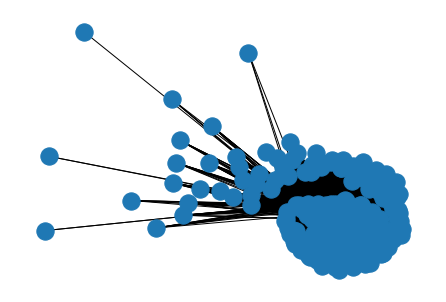

In [229]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
nx.draw(G)
print('number of nodes =',G.number_of_nodes(),', number of edges =', G.number_of_edges(),'. number of components =',c) 

In [70]:
for component in list(nx.connected_components(G)):
    c += 1
    if len(component)<70:
        for node in component:
            G.remove_node(node)

In [58]:
from matplotlib import pylab
def save_graph(graph, file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(40, 40))
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)
    
save_graph(G,'g')
print('number of nodes = ', G.number_of_nodes(),
     'number of edges = ', G.number_of_edges())

NameError: name 'plt' is not defined

In [73]:
c=0
for component in list(nx.connected_components(G)):
    c += 1
print(c)

3


In [78]:
G.number_of_nodes()

719